<a href="https://colab.research.google.com/github/1z2s3e4v/dataScience-hw3-Panorama/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
array_of_img = [] # Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
                         
def SIFT(inputname):
    read_directory(inputname)
    #use: len(array_of_img) for looping the image, array_of_img[0],
    #array_of_img[1],array_of_img[2],...for processing each image
    #Start SIFT here


    #End of SIFT here and use imageoutput for your output
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

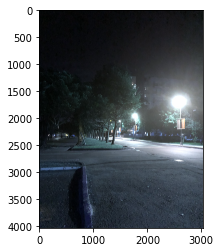

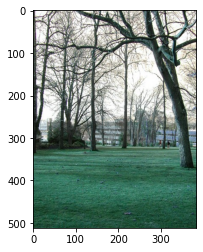

In [18]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):   
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()